In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from tqdm import tqdm



In [2]:
# 設定隨機種子
seed_value = 421
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)

# 確保在使用 CUDA 時的確定性
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [3]:
# 讀取資料
data = pd.read_excel('C:/Users/fishd/Desktop/Github/FTIR_dust/dataset/南科_389(未調).xlsx')



In [4]:
data.head()

,number,4000,3999,3998,3997,3996,3995,3994,3993,3992,...,753,752,751,750,TC(%),TOC(%),TN(%),TIC(%),ROC(%),LOC(%)
0,690_1100,98.386066,98.385632,98.385519,98.385715,98.386049,98.386313,98.386415,98.386416,98.386429,...,95.146887,95.217958,95.293845,95.368455,0.891328,0.862425,0.060197,0.028903,0.019,0.791
1,690_1800,100.213362,100.212912,100.212465,100.212024,100.211591,100.211197,100.210921,100.210820,100.210801,...,96.131446,96.229433,96.310792,96.379032,0.157390,0.134172,0.034999,0.023218,0.009,0.084
2,690_3130,100.492348,100.492714,100.492748,100.492349,100.491656,100.490884,100.490193,100.489664,100.489315,...,99.047922,99.092978,99.128502,99.153174,0.492273,0.413449,0.055390,0.078825,0.017,0.351
3,690_3560,99.551017,99.549664,99.549139,99.549516,99.550425,99.551282,99.551831,99.552236,99.552719,...,95.627448,95.715538,95.793689,95.861151,0.332968,0.308505,0.055784,0.024463,0.011,0.246
4,690_4240,98.342202,98.342205,98.342463,98.342946,98.343480,98.343781,98.343676,98.343267,98.342840,...,93.609685,93.720093,93.829831,93.940271,0.323992,0.116998,0.039095,0.206994,0.021,0.087


In [5]:
# 設定 TOC % 欄位名稱
toc_column = 'LOC(%)'

# 計算 IQR（四分位距）
Q1 = data[toc_column].quantile(0.25)
Q3 = data[toc_column].quantile(0.75)
IQR = Q3 - Q1

# 定義離群值範圍
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 過濾掉離群值
data_filtered = data[(data[toc_column] >= lower_bound) & (data[toc_column] <= upper_bound)]

# 顯示過濾後的資料
data_filtered.head()


,number,4000,3999,3998,3997,3996,3995,3994,3993,3992,...,753,752,751,750,TC(%),TOC(%),TN(%),TIC(%),ROC(%),LOC(%)
1,690_1800,100.213362,100.212912,100.212465,100.212024,100.211591,100.211197,100.210921,100.210820,100.210801,...,96.131446,96.229433,96.310792,96.379032,0.157390,0.134172,0.034999,0.023218,0.009,0.084
2,690_3130,100.492348,100.492714,100.492748,100.492349,100.491656,100.490884,100.490193,100.489664,100.489315,...,99.047922,99.092978,99.128502,99.153174,0.492273,0.413449,0.055390,0.078825,0.017,0.351
3,690_3560,99.551017,99.549664,99.549139,99.549516,99.550425,99.551282,99.551831,99.552236,99.552719,...,95.627448,95.715538,95.793689,95.861151,0.332968,0.308505,0.055784,0.024463,0.011,0.246
4,690_4240,98.342202,98.342205,98.342463,98.342946,98.343480,98.343781,98.343676,98.343267,98.342840,...,93.609685,93.720093,93.829831,93.940271,0.323992,0.116998,0.039095,0.206994,0.021,0.087
5,690_5400,98.917797,98.917080,98.916566,98.916323,98.916189,98.915993,98.915714,98.915441,98.915271,...,97.160642,97.213835,97.266149,97.312994,0.361418,0.131209,0.033538,0.230208,0.021,0.101


In [6]:
# 分離舊資料與新資料
old_data = data_filtered.iloc[:, 1:-6]
old_data.head()

,4000,3999,3998,3997,3996,3995,3994,3993,3992,3991,...,759,758,757,756,755,754,753,752,751,750
1,100.213362,100.212912,100.212465,100.212024,100.211591,100.211197,100.210921,100.210820,100.210801,100.210647,...,95.444102,95.552063,95.666950,95.783952,95.901825,96.019636,96.131446,96.229433,96.310792,96.379032
2,100.492348,100.492714,100.492748,100.492349,100.491656,100.490884,100.490193,100.489664,100.489315,100.489137,...,98.850638,98.875477,98.899561,98.926600,98.959919,99.001136,99.047922,99.092978,99.128502,99.153174
3,99.551017,99.549664,99.549139,99.549516,99.550425,99.551282,99.551831,99.552236,99.552719,99.553209,...,95.191306,95.252919,95.311862,95.372839,95.446073,95.534033,95.627448,95.715538,95.793689,95.861151
4,98.342202,98.342205,98.342463,98.342946,98.343480,98.343781,98.343676,98.343267,98.342840,98.342597,...,92.857026,92.989700,93.116835,93.239310,93.364374,93.490769,93.609685,93.720093,93.829831,93.940271
5,98.917797,98.917080,98.916566,98.916323,98.916189,98.915993,98.915714,98.915441,98.915271,98.915221,...,96.809515,96.869173,96.930221,96.990065,97.049010,97.106191,97.160642,97.213835,97.266149,97.312994


In [7]:
# 分離舊資料與新資料
new_data = data_filtered.iloc[-1, 1:-6]
#old_data.columns = old_data.columns.astype(str)

# 對資料進行標準化
scaler = StandardScaler()
old_data_scaled = scaler.fit_transform(old_data)
new_data_scaled = scaler.transform(new_data.values.reshape(1, -1))

# 使用 PCA 進行降維
pca = PCA(n_components=200)
X_pca = pca.fit_transform(old_data_scaled)
new_pca = pca.transform(new_data_scaled)



In [8]:
# 目標變量
target = data_filtered.iloc[:, -1]
print(target.head())
# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_pca, target, test_size=0.2, random_state=seed_value)

# 將資料轉換為 PyTorch Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# 調整輸入形狀以適應 CNN 模型
X_train_tensor = X_train_tensor.unsqueeze(1)  # 增加 channel 維度
X_test_tensor = X_test_tensor.unsqueeze(1)  # 增加 channel 維度

# 設定 DataLoader
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



1    0.084
2    0.351
3    0.246
4    0.087
5    0.101
Name: LOC(%), dtype: float64


In [9]:
# 定義 CNN 模型
class CNNRegressor(nn.Module):
    def __init__(self, input_shape):
        super(CNNRegressor, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.pool1 = nn.MaxPool1d(kernel_size=3)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2112, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

input_shape = X_train_tensor.shape[1]
model = CNNRegressor(input_shape).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)



In [10]:
from torchinfo import summary
summary(model, device=device)

Layer (type:depth-idx)                   Param #
CNNRegressor                             --
├─Conv1d: 1-1                            256
├─MaxPool1d: 1-2                         --
├─Conv1d: 1-3                            10,304
├─MaxPool1d: 1-4                         --
├─Flatten: 1-5                           --
├─Linear: 1-6                            131,200
├─Linear: 1-7                            8,256
├─Linear: 1-8                            2,080
├─Linear: 1-9                            33
Total params: 152,129
Trainable params: 152,129
Non-trainable params: 0

In [12]:
# 訓練模型
epochs = 200
model.train()
train_losses = []
val_losses = []

for epoch in tqdm(range(epochs), desc=f"Train epochs {epochs}"):
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.flatten(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # 驗證損失
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs.flatten(), y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    model.train()

# 評估模型
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor.to(device)).cpu().numpy().flatten()
    y_pred_test = model(X_test_tensor.to(device)).cpu().numpy().flatten()

train_mse = mean_squared_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f'train MSE: {train_mse}, train R²: {train_r2}')
print(f'test MSE: {test_mse}, test R²: {test_r2}')



Train epochs 200:   0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x2112 and 1024x128)

In [12]:
y_pred_train = model(X_train_tensor.to(device)).cpu().detach().numpy().flatten()
y_pred_test = model(X_test_tensor.to(device)).cpu().detach().numpy().flatten()

print("y_pred_train shape:", y_pred_train.shape) 


y_pred_train shape: (297,)


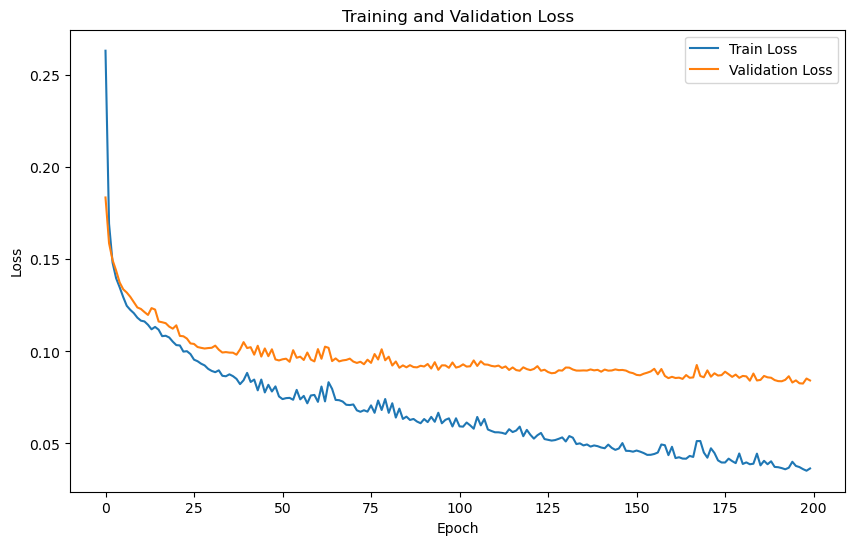

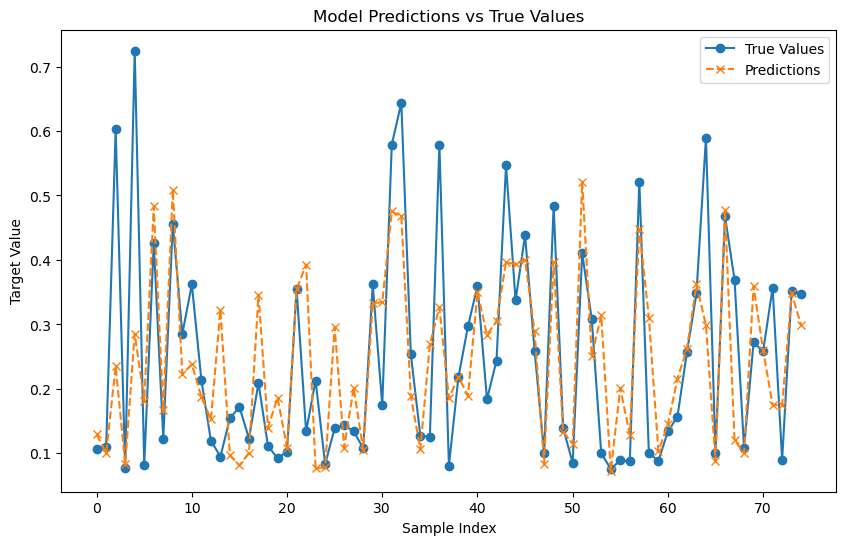

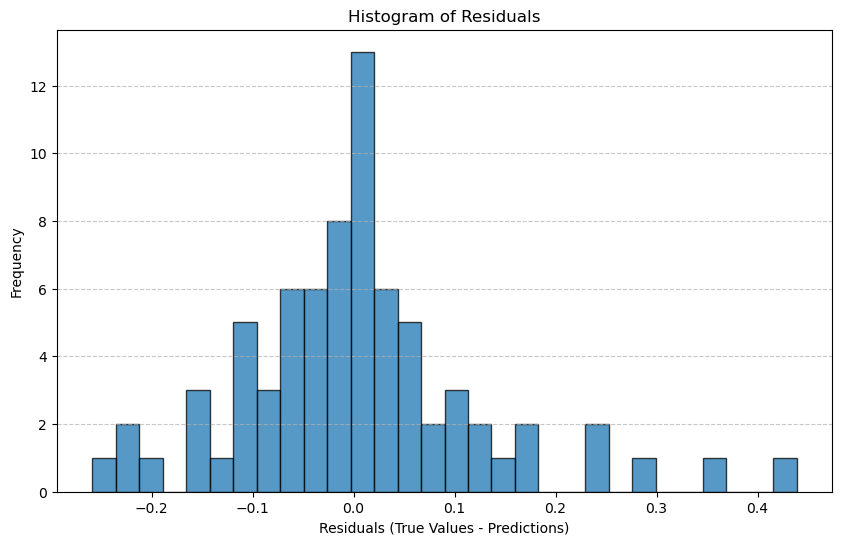

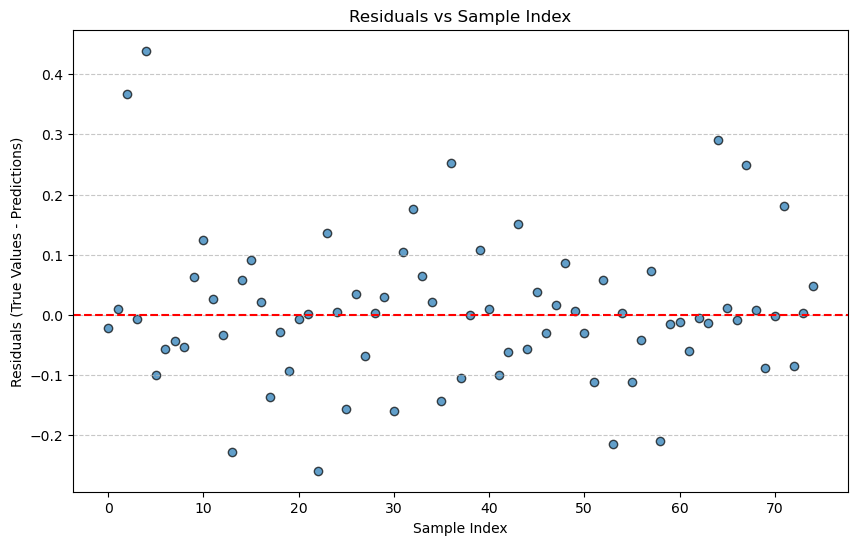

In [13]:
# 繪製訓練和驗證損失曲線
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# 繪製預測結果與真實值的比較
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='True Values', marker='o')
plt.plot(y_pred_test, label='Predictions', linestyle='--', marker='x')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title('Model Predictions vs True Values')
plt.show()


# 計算差值（實際值減去預測值）
residuals = y_test.values - y_pred_test

# 繪製直方圖
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.75, edgecolor='black')
plt.xlabel('Residuals (True Values - Predictions)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 計算誤差（Residuals）
residuals = y_test.values - y_pred_test

# 繪製散點圖
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.7, edgecolor='black')
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)  # 繪製基準線 y=0
plt.xlabel('Sample Index')
plt.ylabel('Residuals (True Values - Predictions)')
plt.title('Residuals vs Sample Index')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [14]:
# 使用模型對新資料進行預測
model.eval()  # 設置模型為推論模式（evaluation mode）
X_new_tensor = torch.tensor(new_pca, dtype=torch.float32).unsqueeze(0).to(device)  # 增加 batch 維度
with torch.no_grad():  # 關閉梯度計算
    prediction = model(X_new_tensor).cpu().numpy().flatten()

print("Prediction for new data:", prediction[0])
print('True Value:', data.iloc[-1, -2])


Prediction for new data: 0.4825614
True Value: 0.005442790901713956
